# Monte-Carlo Simulation of a First-Come First Serve 3D Managed Print Service

by James Gopsill

<hr>

To do...

### Citation

```
@article{gopsill2017,
	doi = {10.1177/0954405417708217},
	url = {https://doi.org/10.1177%2F0954405417708217},
	year = 2017,
	month = {jun},
	publisher = {{SAGE} Publications},
	pages = {095440541770821},
	author = {James A Gopsill and Ben J Hicks},
	title = {Investigating the effect of scale and scheduling strategies on the productivity of 3D managed print services},
	journal = {Proceedings of the Institution of Mechanical Engineers, Part B: Journal of Engineering Manufacture}
}
```

In [1]:
# A line of code that jupyter notebook uses to plot the images inline with the code and text
%matplotlib inline
# Custom settings for the python notebook to save images as svg rather than png
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import matplotlib.pyplot as plt
import numpy as np
import pickle

## Creating the function of the model

In [2]:
def fcfs_model(printer_options, print_bed_list):
    length_of_day = 10 * 60 # Hours * Minutes
    number_of_printers = np.random.choice( printer_options )
    chance_of_a_student_appearing = 0.6 + 0.4 * ( np.random.rand() )
    
    # Initialise the printers
    printers = []
    for i in range(0, number_of_printers):
        printers.append( -1 ) # Initialising the printers 1 minute before the day starts
    
    # load the potential printers that could be used
    number_of_prints_available = len( print_bed_list )
    
    # set-up the stats that we wish to collect
    number_of_items_printed = 0
    number_of_submissions = 0
    time_active = np.zeros( (number_of_printers, length_of_day) )
    students_turned_away = 0
    number_of_items_wished_to_print = 0
    number_of_students = 0
    
    # run the model
    for time in range(0, length_of_day):
        # does student appear
        chance = np.random.rand()
        if chance > chance_of_a_student_appearing:
            # student appears
            number_of_students = number_of_students + 1
            # is a printer available?
            turned_away = True
            # run through each printer to see if it is active
            for n in range(0, number_of_printers):
                if printers[n] < time:
                    # printer is available
                    # student selects item to print
                    idx = np.random.randint( number_of_prints_available )
                    printers[n] = time + print_bed_list[idx]['duration'] + 10 # +10 minutes for change over
                    number_of_submissions = number_of_submissions + 1
                    number_of_items_printed = number_of_items_printed + print_bed_list[idx]['no_of_parts']
                    number_of_items_wished_to_print = number_of_items_wished_to_print + print_bed_list[idx]['no_of_parts']
                    turned_away = False
                    break
                    
            if turned_away:
                # select a print file that the student wished to print
                idx = np.random.randint( number_of_prints_available )
                number_of_items_wished_to_print = number_of_items_wished_to_print + print_bed_list[idx]['no_of_parts']
                students_turned_away = students_turned_away + 1
        
        # record if the printer is active during this time
        for n in range(0, number_of_printers):
            if printers[n] > time:
                # printer is active
                time_active[n, time] = 1
    
    
    # Check if there has been submissions to the printer service       
    if number_of_submissions > 0:
        demand_ratio = number_of_items_printed / number_of_items_wished_to_print
    else:
        # print('No Submissions:', number_of_students)
        demand_ratio = 0
    # Calculate the level of printer activity
    printer_activity = np.count_nonzero(time_active) / time_active.size
    # return the values
    return(number_of_printers, number_of_students, demand_ratio, printer_activity)

## Running the model

In [3]:
# Run the Student Model
number_of_iterations = 15000
fcfs_results = np.zeros( (number_of_iterations, 4) )
printers = [1, 5, 10, 15, 20]
print_bed_list = pickle.load( open('print_bed_list.pkl', 'rb') )

for i in range(0, number_of_iterations):
    if i % 2500 == 0:
        print(i, 'Iterations')
    
    ans = fcfs_model(printers, print_bed_list)
    fcfs_results[i, 0] = ans[0] # Number of Printers
    fcfs_results[i, 1] = ans[1] # Number of Students Wishing to Submit
    fcfs_results[i, 2] = ans[2] # Demand Ratio
    fcfs_results[i, 3] = ans[3] # Printer Activity

print(i, 'Iterations')

0 Iterations
2500 Iterations
5000 Iterations
7500 Iterations
10000 Iterations
12500 Iterations
14999 Iterations


## Plotting the results

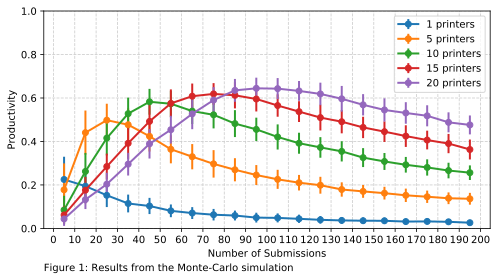

In [4]:
means_plus_std = []
means_minus_std = []

plt.figure(figsize=(8,4))

for printer in printers:
    x = []
    means = []
    stds = []
    
    for bin in range(0, 20):
        values = []
        demand_min = bin * 10
        demand_center = demand_min + 5
        demand_max = demand_min + 10
        for result in fcfs_results:
            if result[1] > demand_min and result[1] <= demand_max and result[0] == printer:
                values.append( result[2] * result[3] )
        
        if ( len(values) > 0 ):
            x.append( demand_center )
            means.append( np.mean(values) )
            stds.append( np.std(values) )
        else:
            print( printer, demand_center )
        
    plt.errorbar(x, means, yerr=stds, label=str(printer)+' printers', fmt='-o', lw=2, zorder=10)

plt.ylim(0, 1)
plt.xticks(np.arange(0, 210, 10))
plt.grid(color=(0.8,0.8,0.8), linestyle='--')
plt.xlabel('Number of Submissions')
plt.ylabel('Productivity')
l = plt.legend()
l.set_zorder(11)
plt.annotate('Figure 1: Results from the Monte-Carlo simulation', (0,0), (0, -35), xycoords='axes fraction', textcoords='offset points', va='top')
plt.show()